# Hypothese 1

### Die Trinkgeld-Rate (Tip Percentage), gemessen als Verhältnis von Trinkgeld zu Gesamtbetrag, wird signifikant durch die Tageszeit beeinflusst.

In [1]:
import sys
from pathlib import Path

# Pfad zum Root-Verzeichnis setzen (eine Ebene über notebooks/)
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Standard Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols

try:
    from src.utils_stats import iqr, trimmed_mean, tukey_fences, tukey_outliers, modified_z_score, ecdf, z_score, create_na_table
    from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq
    print("Custom 'src' Module erfolgreich geladen.")
except ImportError:
    print("Hinweis: Custom 'src' Module nicht gefunden. Nutze Standard-Bibliotheken.")

# Grafik-Style
sns.set_theme(style="whitegrid")

Projekt-Root hinzugefügt: /home/benjamin/HSG/Statistik/Project
Custom 'src' Module erfolgreich geladen.


# Analyse der Trinkgeld-Rate nach Tageszeit

## 1. Hypothese und Forschungsfrage
**Hypothese:** Die Trinkgeld-Rate (*Tip Percentage*), gemessen als Verhältnis von Trinkgeld zu Gesamtbetrag, wird signifikant durch die Tageszeit beeinflusst.

**Vorgehensweise basierend auf den Vorlesungen:**
1.  **Feature Engineering:** Berechnung der `tip_pct`.
2.  **EDA:** Visueller Vergleich der Gruppen (Boxplots/Violinplots).
3.  **Voraussetzungsprüfung:** Sind die Daten normalverteilt? (Shapiro-Wilk, QQ-Plot). Sind die Varianzen gleich? (Levene-Test).
4.  **Signifikanztest:** Auswahl des passenden Tests (t-Test oder Mann-Whitney-U).
5.  **Effektstärke:** Berechnung von Cohen's d zur Beurteilung der Relevanz.
6.  **Modellierung:** Überprüfung mittels linearer Regression.

In [2]:
# Datensatz laden
PATH = "../data/Taxi_final_1M_clean.csv"
df = pd.read_csv(PATH)

# Tip Percentage berechnen (Trinkgeld / Gesamtbetrag)
df['tip_pct'] = df['tip_amount'] / df['total_amount']

print("Datensatz Übersicht:")
display(df.head())

print("\nDeskriptive Statistik nach Tageszeit:")
# Stunde extrahieren
# Dies erstellt eine neue Spalte mit Werten von 0 bis 23
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

# Nach Stunde gruppieren
hourly_stats = df.groupby('dropoff_hour')['tip_pct'].describe()

display(hourly_stats)

Datensatz Übersicht:


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,tip_pct
0,2023-02-06 18:31:28,2023-02-06 18:41:28,1.0,2.8,162,113,1,11.4,2.5,2.00,0.0,1.0,19.90,2.5,0.0,10.0,17.0,0.100503
1,2023-01-24 12:53:51,2023-01-24 13:06:09,5.0,2.3,142,48,2,12.1,0.0,0.00,0.0,1.0,16.10,2.5,0.0,12.3,11.2,0.000000
2,2023-02-04 22:58:49,2023-02-04 23:03:11,2.0,1.1,107,107,1,5.8,3.5,1.20,0.0,1.0,12.00,2.5,0.0,4.4,15.5,0.100000
3,2023-02-02 16:39:15,2023-02-02 16:50:39,1.0,2.9,234,249,1,12.1,2.5,3.72,0.0,1.0,22.32,2.5,0.0,11.4,15.5,0.166667
4,2023-02-15 21:08:32,2023-02-15 21:14:12,1.0,1.2,230,48,1,7.2,1.0,2.44,0.0,1.0,14.64,2.5,0.0,5.7,13.1,0.166667



Deskriptive Statistik nach Tageszeit:


,count,mean,std,min,25%,50%,75%,max
dropoff_hour,,,,,,,,
0,30940.0,0.118955,0.073978,0.0,0.058692,0.165644,0.166667,0.902527
1,20239.0,0.118267,0.074508,0.0,0.057119,0.165775,0.166667,0.957592
2,13206.0,0.116300,0.077415,0.0,0.047460,0.165854,0.166667,0.774424
3,8440.0,0.115294,0.079703,0.0,0.029851,0.165891,0.166667,0.805452
4,5562.0,0.106419,0.084114,0.0,0.000000,0.147059,0.166667,0.866218
5,4845.0,0.103121,0.082732,0.0,0.000000,0.130809,0.166667,0.710900
6,10978.0,0.111564,0.079669,0.0,0.000000,0.146520,0.166667,0.809061
7,22595.0,0.118299,0.074325,0.0,0.060976,0.164179,0.166667,0.761421
8,33847.0,0.122056,0.073095,0.0,0.073529,0.165563,0.166667,0.922222


## 2. Explorative Datenanalyse (EDA)
Wir visualisieren die Verteilung der `tip_pct` für beide Tageszeiten. Ein Violinplot zeigt uns die Dichte der Verteilung, während der Boxplot Mediane und Ausreißer hervorhebt.

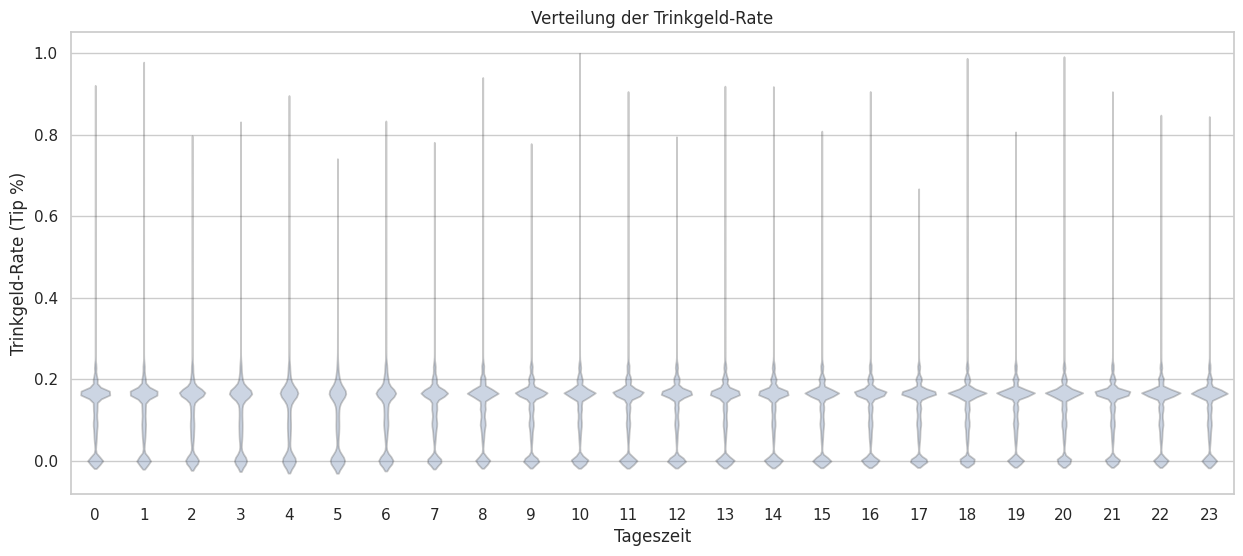

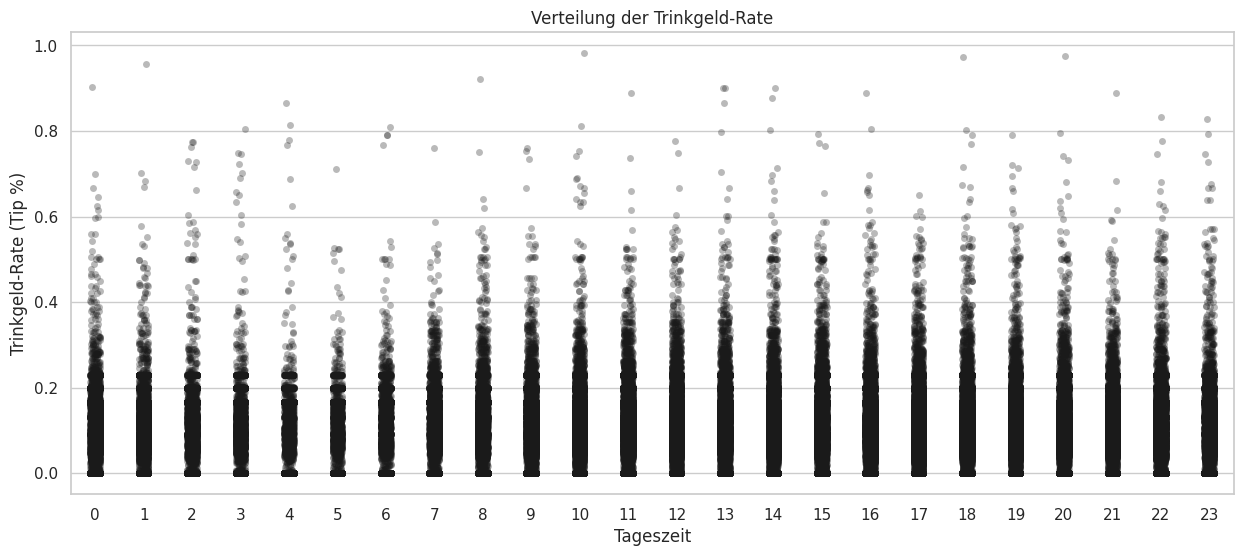

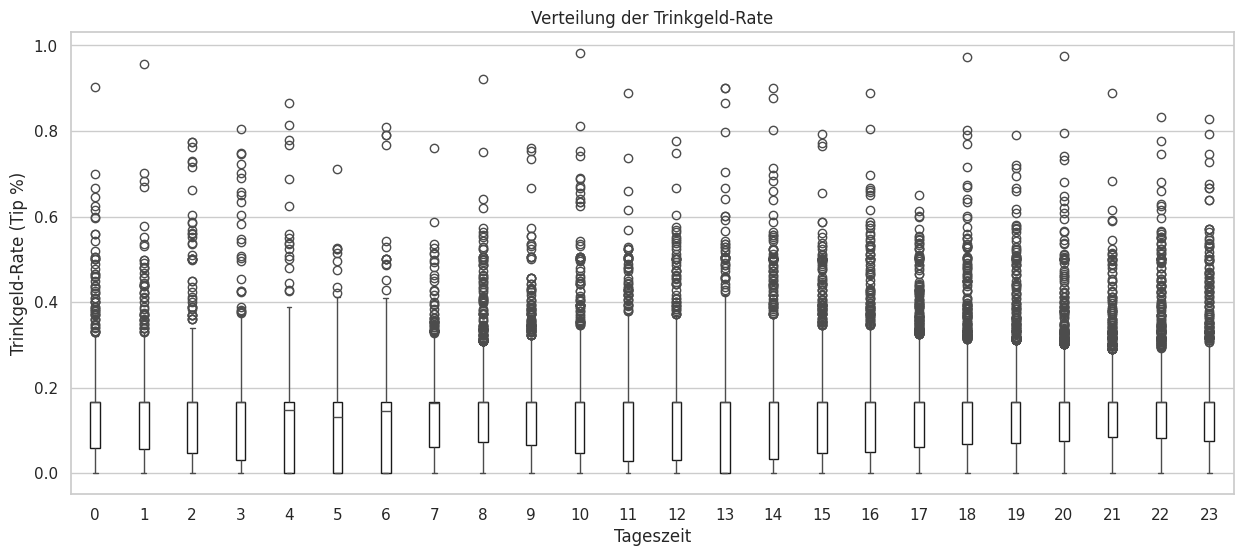

In [7]:
# Plotting
plt.figure(figsize=(15, 6))

# Violinplot für die Verteilung
sns.violinplot(x='dropoff_hour', y='tip_pct', data=df, inner=None, alpha=0.3)

plt.title('Verteilung der Trinkgeld-Rate')
plt.ylabel('Trinkgeld-Rate (Tip %)')
plt.xlabel('Tageszeit')
plt.show()

plt.figure(figsize=(15, 6))
# Swarmplot oder Stripplot für die einzelnen Datenpunkte
sns.stripplot(x='dropoff_hour', y='tip_pct', data=df, color='k', alpha=0.3, jitter=True)

plt.title('Verteilung der Trinkgeld-Rate')
plt.ylabel('Trinkgeld-Rate (Tip %)')
plt.xlabel('Tageszeit')
plt.show()

plt.figure(figsize=(15, 6))
# Boxplot für Median und Quartile
sns.boxplot(x='dropoff_hour', y='tip_pct', data=df, width=0.2, boxprops={'facecolor':'none', 'edgecolor':'k'})

plt.title('Verteilung der Trinkgeld-Rate')
plt.ylabel('Trinkgeld-Rate (Tip %)')
plt.xlabel('Tageszeit')
plt.show()

## 3. Prüfung der Voraussetzungen
Für einen klassischen t-Test sollten die Daten idealerweise normalverteilt sein. Wir prüfen dies visuell mit einem **QQ-Plot** und rechnerisch mit dem **Shapiro-Wilk Test**. Zusätzlich prüfen wir die Varianzhomogenität mit dem **Levene-Test**.

tageszeit
night      422915
midday     345851
morning    198727
Name: count, dtype: int64
Datenpunkte: Morning=198727, Midday=345851, Night=422915


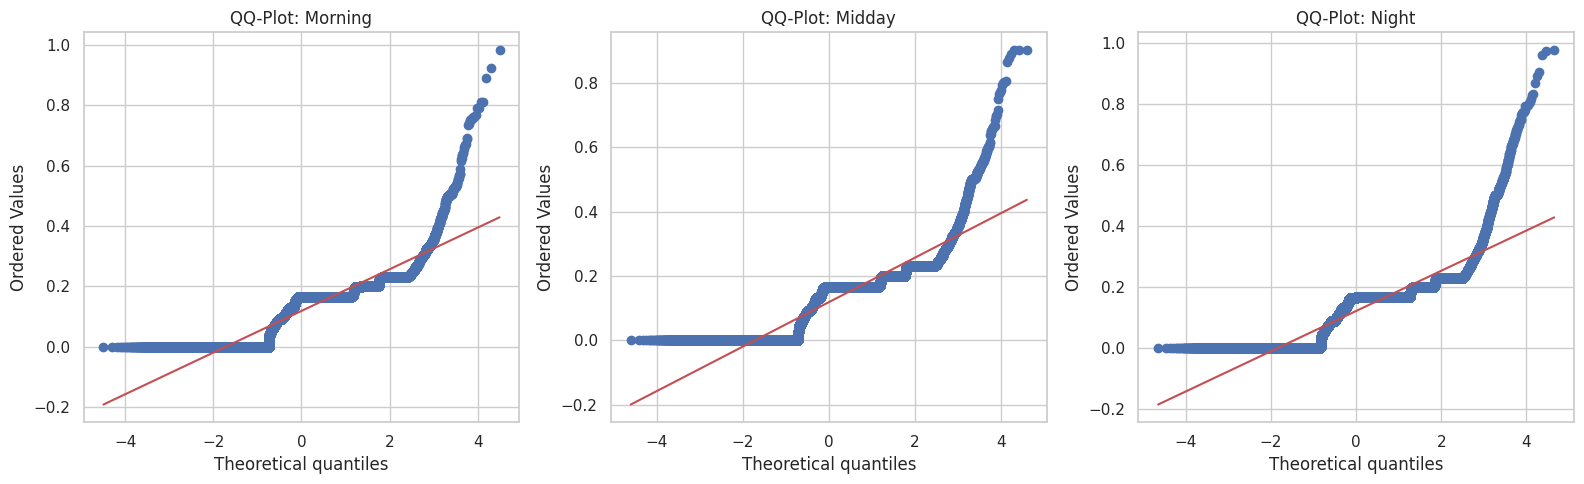


--- Shapiro-Wilk Test (auf 5000er Stichprobe) ---
Morning: p-Wert = 0.00000
Midday:  p-Wert = 0.00000
Night:   p-Wert = 0.00000

--- Levene-Test ---
Levene p-Wert = 0.00000
-> Varianzen sind ungleich


In [11]:
# Daten in Gruppen aufteilen
# Wir setzen erst mal alles auf 'night' (Standardwert)
df['tageszeit'] = 'night'
# Morgens: 6 Uhr bis 11 Uhr
df.loc[(df['dropoff_hour'] >= 6) & (df['dropoff_hour'] < 12), 'tageszeit'] = 'morning'
# Mittags/Nachmittags: 12 Uhr bis 17 Uhr
df.loc[(df['dropoff_hour'] >= 12) & (df['dropoff_hour'] < 18), 'tageszeit'] = 'midday'

print(df['tageszeit'].value_counts())

morning = df[df['tageszeit'] == 'morning']['tip_pct']
midday = df[df['tageszeit'] == 'midday']['tip_pct']
night = df[df['tageszeit'] == 'night']['tip_pct']

# Prüfen, ob Daten da sind
print(f"Datenpunkte: Morning={len(morning)}, Midday={len(midday)}, Night={len(night)}")


# 2. Visuelle Prüfung: QQ-Plots
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

st.probplot(morning, dist="norm", plot=ax[0])
ax[0].set_title("QQ-Plot: Morning")

st.probplot(midday, dist="norm", plot=ax[1])
ax[1].set_title("QQ-Plot: Midday")

st.probplot(night, dist="norm", plot=ax[2]) 
ax[2].set_title("QQ-Plot: Night")

plt.tight_layout()
plt.show()


# Rechnerische Prüfung: Shapiro-Wilk
# WICHTIG: Shapiro-Wilk ist bei 1 Mio Zeilen nicht aussagekräftig (und extrem langsam)!
# Er wird IMMER p < 0.05 ausgeben, weil er bei großen Datenmengen hyper-sensibel ist.
# Wir ziehen hier eine Zufallsstichprobe von 5000 Werten für den Test.

print("\n--- Shapiro-Wilk Test (auf 5000er Stichprobe) ---")
# random_state=42 sorgt dafür, dass das Ergebnis reproduzierbar ist
shapiro_morning = st.shapiro(morning.sample(5000, random_state=42)) 
shapiro_midday = st.shapiro(midday.sample(5000, random_state=42))
shapiro_night = st.shapiro(night.sample(5000, random_state=42))

print(f"Morning: p-Wert = {shapiro_morning.pvalue:.5f}")
print(f"Midday:  p-Wert = {shapiro_midday.pvalue:.5f}")
print(f"Night:   p-Wert = {shapiro_night.pvalue:.5f}")


# Varianzhomogenität: Levene-Test
print("\n--- Levene-Test ---")
levene_stat, levene_p = st.levene(morning, midday, night)
print(f"Levene p-Wert = {levene_p:.5f}")

if levene_p < 0.05:
    print("-> Varianzen sind ungleich")
else:
    print("-> Varianzen sind gleich")

## 4. Durchführung des Hypothesentests

**Methodenwahl:**
Da die QQ-Plots zeigen, dass die Daten nicht perfekt auf der roten Linie liegen (Nicht-Normalverteilung), und der Levene-Test unterschiedliche Varianzen zeigt, verwenden wir den **Mann-Whitney-U Test**.

**Hypothesen:**
* **$H_0$:** Es gibt keinen Unterschied in der Verteilung der Trinkgeld-Rate zwischen Tag und Nacht.
* **$H_1$:** Es gibt einen signifikanten Unterschied.
* **Signifikanzniveau ($\alpha$):** 0.05

In [12]:
# Mann-Whitney-U Test (Nicht-parametrisch)
tag_fahrten = pd.concat([morning, midday])
u_stat, p_val = st.mannwhitneyu(tag_fahrten, night, alternative='two-sided')

print(f"--- Testergebnis ---")
print(f"U-Statistik: {u_stat}")
print(f"p-Wert:      {p_val:.10f}") # Zeige viele Nachkommastellen

alpha = 0.05
if p_val < alpha:
    print("\nEntscheidung: H0 verwerfen.")
    print("Es gibt einen statistisch signifikanten Unterschied in der Trinkgeld-Rate zwischen Tag und Nacht.")
else:
    print("\nEntscheidung: H0 beibehalten.")
    print("Kein signifikanter Unterschied nachweisbar.")

--- Testergebnis ---
U-Statistik: 113752127453.5
p-Wert:      0.0000000000

Entscheidung: H0 verwerfen.
Es gibt einen statistisch signifikanten Unterschied in der Trinkgeld-Rate zwischen Tag und Nacht.
